In [62]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp

In [63]:
def ode_func(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (S + Km)
    dydt = [mu * X, -1/Y_XS * mu * X]
    return dydt

# Solve above system of ODEs    
y0 = [0.130357, 8.19]
T_START = 0
T_END = 4.1
N_SAMPLES = 100
t_sim = np.linspace(T_START, T_END, N_SAMPLES)
sol = solve_ivp(ode_func, [T_START, T_END], y0, t_eval=t_sim, args=(0.6794, 0.0002, 0.2572))

Number of experimental points: 8


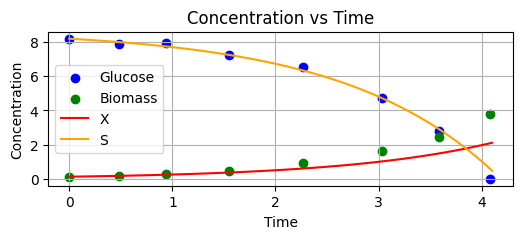

In [49]:
df = pd.read_excel('../data_ceasar.xlsx')
df = df[df['exp'] == 1]
print(f'Number of experimental points: {len(df)}')

fig, ax = plt.subplots(figsize=(6, 2))
ax.scatter(df['Time'], df['Glucose'], label='Glucose', color='blue')
ax.scatter(df['Time'], df['Biomass'], label='Biomass', color='green')
ax.plot(t_sim, sol.y[0], label='X', color='red')
ax.plot(t_sim, sol.y[1], label='S', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Concentration vs Time')
ax.legend()
ax.grid(True)
plt.show()

In [44]:
columns = [f'X_{i}' for i in range(8)] + [f'S_{i}' for i in range(8)] + ['mu_max', 'Km', 'Y_XS']
train = pd.DataFrame(columns=columns)

t_train = np.linspace(T_START, T_END, 8)

for i in range(1000):
    mu_max = np.random.uniform(0.1, 1)
    Km = np.random.uniform(0.0001, 0.1)
    Y_XS = np.random.uniform(0.1, 1)
    sol = solve_ivp(ode_func, [T_START, T_END], y0, t_eval=t_train, args=(mu_max, Km, Y_XS))
    y_train_X = sol.y[0]
    y_train_S = sol.y[1]
    train.loc[len(train)] = np.concatenate([y_train_X, y_train_S, [mu_max, Km, Y_XS]])

Epoch: 0, Loss: 0.5348587036132812
Epoch: 100, Loss: 0.01685420796275139
Epoch: 200, Loss: 0.009655306115746498
Epoch: 300, Loss: 0.006113739684224129
Epoch: 400, Loss: 0.004082490224391222
Epoch: 500, Loss: 0.002864309586584568
Epoch: 600, Loss: 0.0021506939083337784
Epoch: 700, Loss: 0.0017914422787725925
Epoch: 800, Loss: 0.0015520219458267093
Epoch: 900, Loss: 0.0014270464889705181


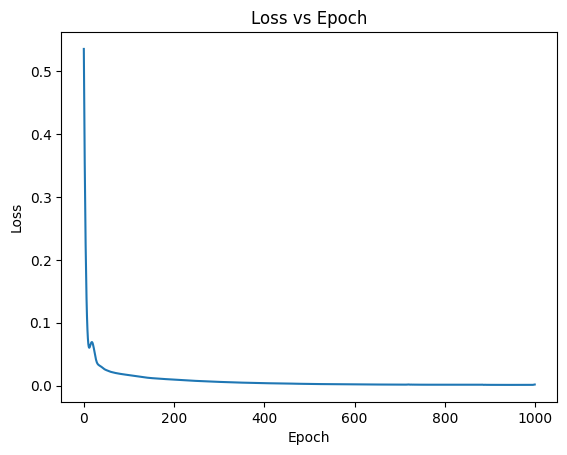

In [51]:
class NN:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def train(self, X, y):
        self.model.train()
        y_pred = self.model(X)
        loss = self.criterion(y_pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            return self.model(X)
        
X = torch.tensor(train.drop(columns=['mu_max', 'Km', 'Y_XS']).values, dtype=torch.float32)
y = torch.tensor(train[['mu_max', 'Km', 'Y_XS']].values, dtype=torch.float32)

model = NN()
losses = []
for i in range(1000):
    loss = model.train(X, y)
    losses.append(loss)
    if i % 100 == 0:
        print(f'Epoch: {i}, Loss: {loss}')
        
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()


mu_max: 0.8465908765792847, Km: 0.07518940418958664, Y_XS: 0.4500011205673218


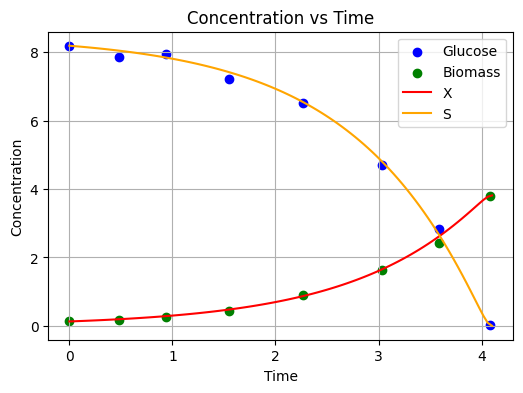

In [61]:
# Evaluate on df experimental data
X_test = df['Biomass'].values
S_test = df['Glucose'].values   

X_test = torch.tensor(X_test, dtype=torch.float32)
S_test = torch.tensor(S_test, dtype=torch.float32)

test = torch.hstack([X_test, S_test]).reshape(1, -1)

mu_max, Km, Y_XS = model.predict(test).detach().numpy()[0]
print(f'mu_max: {mu_max}, Km: {Km}, Y_XS: {Y_XS}')

# Solve ODEs with estimated parameters
sol = solve_ivp(ode_func, [T_START, T_END], y0, t_eval=t_sim, args=(mu_max, Km, Y_XS))

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df['Time'], df['Glucose'], label='Glucose', color='blue')
ax.scatter(df['Time'], df['Biomass'], label='Biomass', color='green')
ax.plot(t_sim, sol.y[0], label='X', color='red')
ax.plot(t_sim, sol.y[1], label='S', color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Concentration vs Time')
ax.legend()
ax.grid(True)
plt.show()